<a href="https://colab.research.google.com/github/AndresMontesDeOca/TimeSeries/blob/main/Machete_TS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machete Series Temporales

## Imortamos Librerias

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf


import warnings
warnings.filterwarnings('ignore')

## Cargamos el Dataset

In [2]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

################################# Datasets ###################################
# Air Pasangers
id = '1L2Ww1zULOaJauVF370DFAziq_Mu19nj9'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('AirPassengers.csv')
data = pd.read_csv('AirPassengers.csv') # Cargamos el Dataset

In [3]:
# url='https://raw.githubusercontent.com/sebcalcagno/AnalisisSeriesTemporales/main/Index2018.csv'
# raw_csv_data = pd.read_csv(url)
# data = raw_csv_data.copy()

# print(data.info())
# data.head()

## Pre-Procesamiento
- Periodo: Frecuencia con la que se repite un patrón en la serie temporal
- Lag: Distancia temporal entre dos observaciones

In [4]:
# Convert the 'Month' column to a datetime data type
data['Month'] = pd.to_datetime(data['Month'])

# Set the 'Month' column as the index of the dataframe
data.set_index('Month', inplace=True)

# Deberia setear la frecuencia?
# data.asfreq('m').head() # Mes

# Adaptamos distintas frecuencias temporales
# display(data.asfreq('b').head()) # Business Day
# data.asfreq('d').head() # Completa dias faltantes con null
# data.asfreq('m').head() # Mes
# data.resample(rule='QS').max # Agrupa por Cuartos, y muestra el Max de cada uno


In [5]:
data.head(13)

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
1949-06-01,135
1949-07-01,148
1949-08-01,148
1949-09-01,136


## Visualizacion

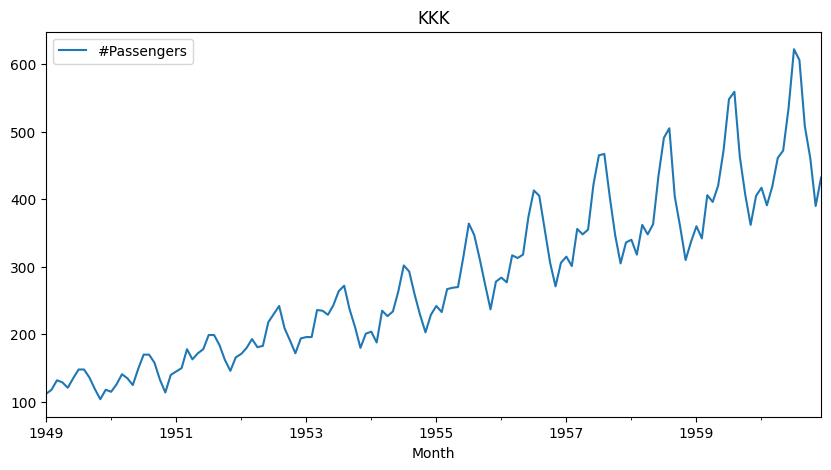

In [6]:
# Visualizamos
data.plot(figsize=(10, 5), title='KKK')
# plt.plot(data)

plt.show()

## Stationarity Check

### Grafico: Moving Averages
- The trend component of a time series represents a persistent, long-term change in the mean of the series
- The idea behind MA is to smooth out any short-term fluctuations in the series, so that only long-term changes remain (trend)
- Media y Desvio deberian ser constantes


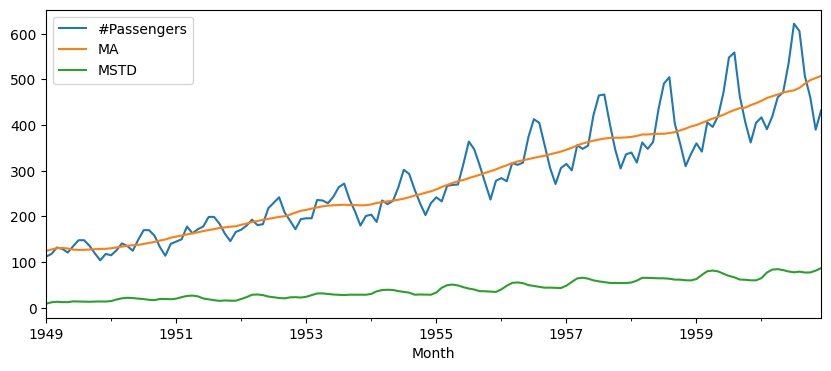

In [7]:
# Calculate Moving Average
ma = data.rolling(window=12, center=True, min_periods=6).mean().rename(columns={'#Passengers':'MA'})
mstd = data.rolling(window=12, center=True, min_periods=6).std().rename(columns={'#Passengers':'MSTD'})

# Concatenate with the main dataset
# data = pd.concat([data, ma, mstd], axis=1)

# Plot
pd.concat([data, ma, mstd], axis=1).plot(figsize=(10, 4)) # xlim=['2019-01-01', '2024-10-10']
plt.show()

### Analitico: Augmented Dickey–Fuller Test (ADCF)
H0: La serie es No-Estacionaria

In [8]:
from statsmodels.tsa.stattools import adfuller
# from statsmodels.tsa.stattools import acf, pacf

# Realizo el test y me traigo solo el p-value
adfuller(data['#Passengers'])[1]

# Acepto H0

0.991880243437641

### Grafico: Seasonal Decompose

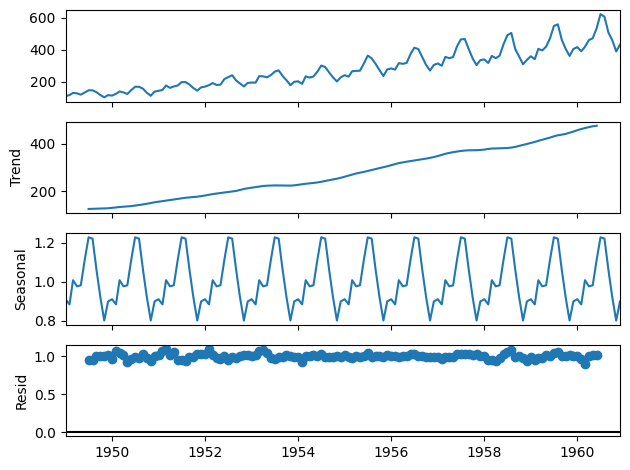

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

data_dec = seasonal_decompose(data, model='multiplicative', period=12) # aditive

data_dec.plot()
# data_dec.trend.plot()
# data_dec.seasonal.plot()
# data_dec.resid.plot()

plt.show()

## Grafico: Funcion de Autocorrelacion (ACF)
- Mide la correlación entre una serie y su versión desplazada en el tiempo
- Ayuda a determinar el orden de un modelo AR\
Trend = Decrece Linealmente. Memoria larga: Se necesitan muchos periodos para resumir el infinito pasado\
Seasonality = Aparecen Valles

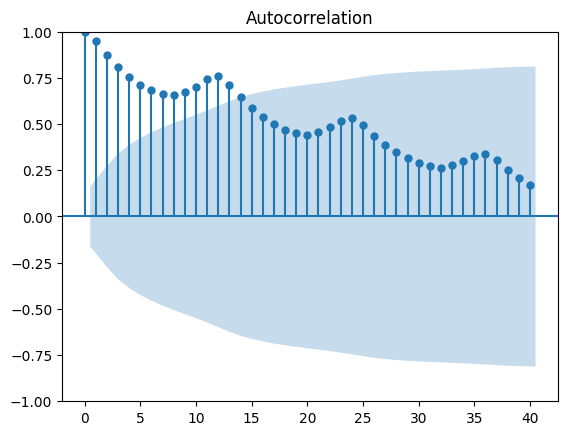

In [10]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(data, lags=40)
plt.show()

In [11]:
# Creo una funcion para unificar todos los distintos tests
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

def StationarityTest (df, period):
  # Guardo el nombre de la Serie
  column_name = df.columns[0]

  # ADCF Test and Print P-Value
  pvalue = adfuller(df[column_name])[1]
  print('P-Value:', pvalue)

  # Calculate Moving Averages and Plot
  ma = df.rolling(window=period, center=True, min_periods=int(period/2)).mean().rename(columns={column_name:'MA'})
  mstd = df.rolling(window=period, center=True, min_periods=int(period/2)).std().rename(columns={column_name:'MSTD'})
  pd.concat([df, ma, mstd], axis=1).plot(figsize=(10, 4))
  plt.show()

  # Seasonal Decompose
  df_dec = seasonal_decompose(df, model='aditive')
  df_dec.plot()

  # ACF Autocorrelation Test
  plot_acf(df, lags=period)
  plt.show()

  return None

## Aplicamos una Transformacion y la Graficamos

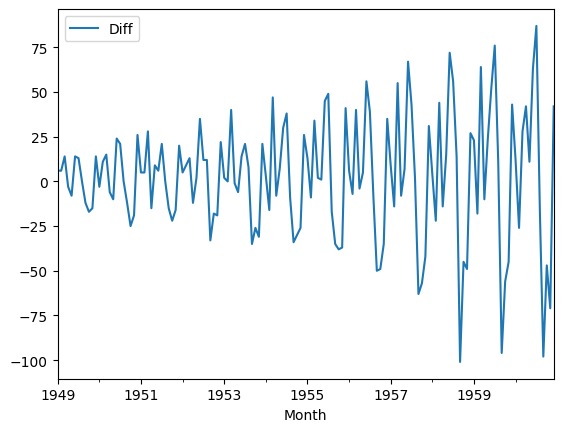

In [12]:
# Calculamos la diferencia con el anterior
data_t1 = data.diff(1).fillna(method='bfill').rename(columns={'#Passengers':'Diff'})

# Graficamos la Serie transformada
data_t1.plot()
plt.show()

## Comprobamos la Stationarity de la Transformada

P-Value: 0.05142220658905923


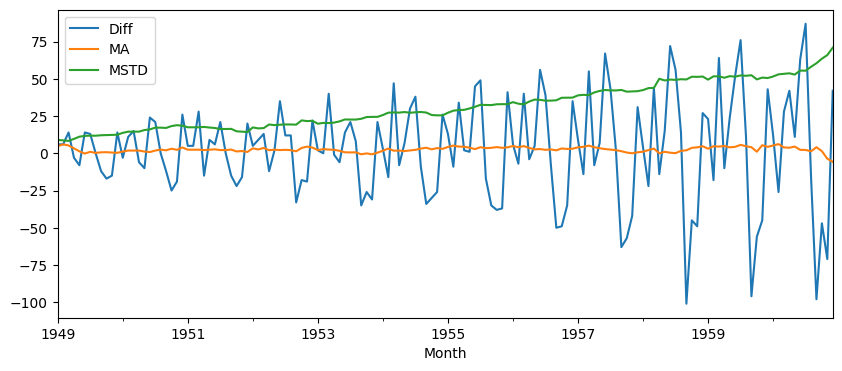

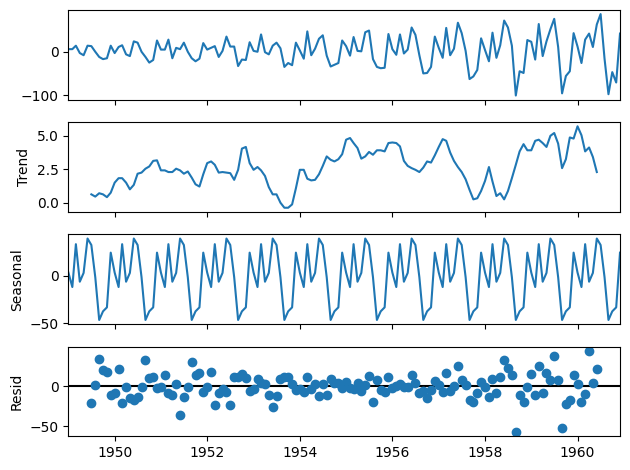

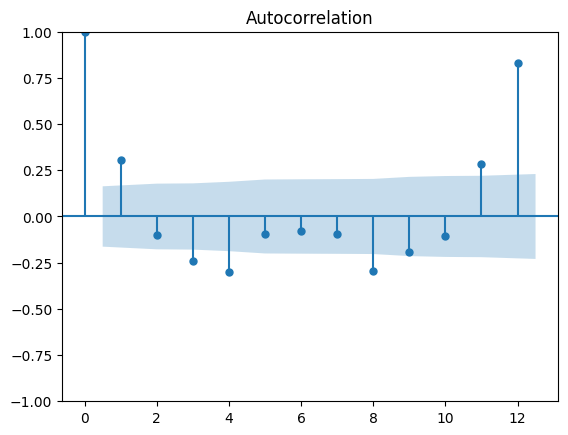

In [13]:
# Comprobamos su Stationarity
StationarityTest(data_t1, 12)

## Modelo AR-MA(p, q)
- **AR**: Historia, p valores relevantes pasados que pueden explicar el comportamiento actual
- **MA**: q valores anteriores de los ruidos blancos, que dan flexibilidad al modelo, lo que no se puede describir